In [1]:
library(tidyverse)
library(ggplot2)
options(repr.matrix.max.rows = 20)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [30]:
# download and simplify the bee dataset

bee_df_ungrouped <- read.csv("https://files.ontario.ca/moe_mapping/downloads/4Other/PHAP/Bumble_Bee_Public_Data.csv") |>
    select(1:7, contains("total")) |>
    mutate(site_type = case_when(`Site.Type` == "Agri" ~ "Agricultural",
                                 `Site.Type` == "Agriculture" ~ "Agricultural",
                                 TRUE ~ `Site.Type`)) |>
    rename(
        county = `ï..County`,
        site_id = `MOECC.Site.Number`,
        year = Year) |>
    filter(site_type != "") |>
    pivot_longer(`bimaculatus.total`:`flavidus.total`,
                 values_to = "no_of_bees", names_to = "species") |>
    select(county, year, site_id, site_type, no_of_bees) |>
    group_by(site_id, site_type)

bee_df <- bee_df_ungrouped |>
    group_by(site_id, site_type) |>
    summarise(bees_per_site = sum(no_of_bees)) |>
    arrange(site_id)

bee_df_ungrouped |> filter(site_id == 3)

beed_df

`summarise()` has grouped output by 'site_id'. You can override using the `.groups` argument.



county,year,site_id,site_type,no_of_bees
<chr>,<int>,<int>,<chr>,<int>
Middlesex Centre,2015,1,Agricultural,7
Middlesex Centre,2015,1,Agricultural,1
Middlesex Centre,2015,1,Agricultural,3
Middlesex Centre,2015,1,Agricultural,0
Middlesex Centre,2015,1,Agricultural,1
Middlesex Centre,2015,1,Agricultural,0
Middlesex Centre,2015,1,Agricultural,0
Middlesex Centre,2015,1,Agricultural,1
Middlesex Centre,2015,1,Agricultural,0


ERROR: Error in eval(expr, envir, enclos): object 'beed_df' not found


In [12]:
summary(bee_df)

    site_id       site_type         bees_per_site   
 Min.   : 1.00   Length:93          Min.   :  0.00  
 1st Qu.:17.00   Class :character   1st Qu.: 13.00  
 Median :30.00   Mode  :character   Median : 32.00  
 Mean   :31.62                      Mean   : 46.62  
 3rd Qu.:46.00                      3rd Qu.: 69.00  
 Max.   :67.00                      Max.   :235.00  

In [13]:
glimpse(bee_df)

Rows: 93
Columns: 3
Groups: site_id [67]
$ site_id       <int> 1, 2, 3, 4, 5, 5, 6, 7, 7, 8, 9, 9, 10, 10, 11, 12, 12, ~
$ site_type     <chr> "Agricultural", "Agricultural", "Agricultural", "Agricul~
$ bees_per_site <int> 73, 25, 20, 73, 0, 48, 57, 151, 115, 32, 15, 49, 11, 90,~


In [14]:
table(bee_df$site_type)


        Agricultural              Natural Semi-natural remnant 
                  45                   24                   24 

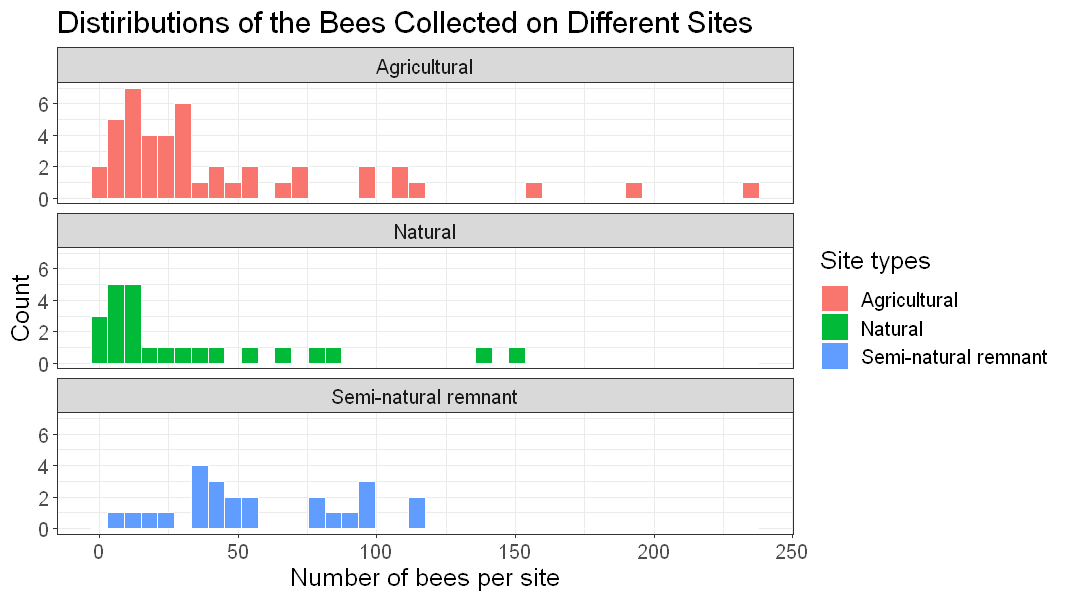

In [15]:
# Distiributions of the bees collected on different sites (Histogram)

bee_df_hist <- ggplot(bee_df) +
    aes(x = bees_per_site,
        fill = site_type) +
    geom_histogram(bins = 40, color = 'white') +
    facet_wrap(~site_type, ncol = 1) +
    labs(x = "Number of bees per site",
         y = "Count",
         fill = "Site types",
         title = "Distiributions of the Bees Collected on Different Sites"
         ) +
    theme_bw() +
    theme(text =  element_text(size = 15))
    

bee_df_hist

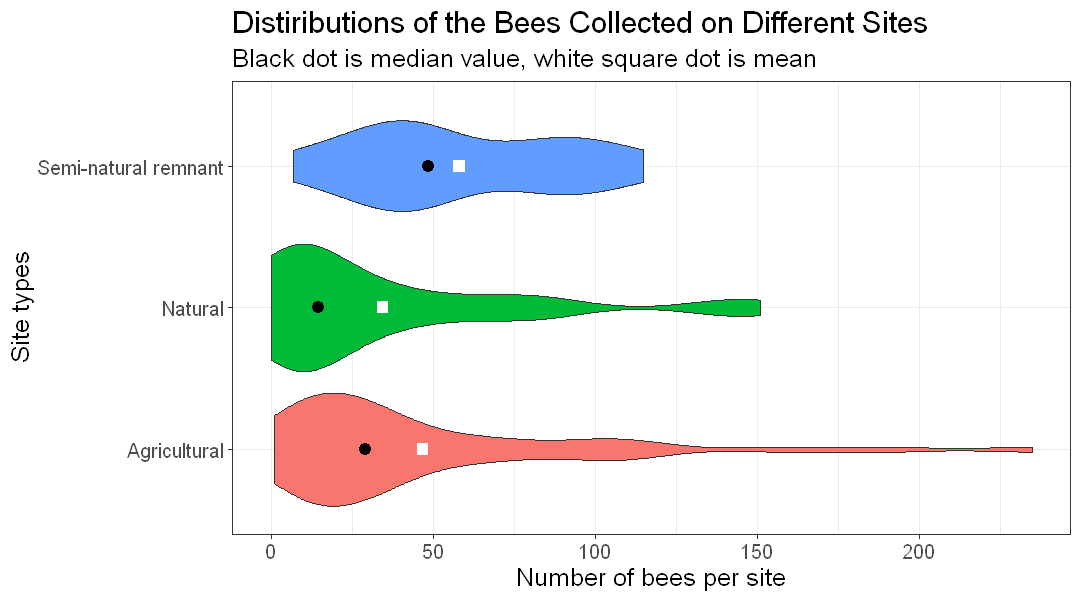

In [26]:
# Distiributions of the bees collected on different sites (Violin Plot with Mean)

options(repr.plot.width=9, repr.plot.height=5)

bee_df_plot <- ggplot(bee_df) +
    aes(y = site_type,
        x = bees_per_site,
        fill = site_type) +
    geom_violin() +
    geom_point(stat = "summary", fun = median, size = 3) +
    geom_point(stat = "summary", fun = mean, size = 3,
               shape = 15, color = "white") +
    labs(x = "Number of bees per site",
         y = "Site types",
         fill = "Site types",
         title = "Distiributions of the Bees Collected on Different Sites",
         subtitle = "Black dot is median value, white square dot is mean"
         ) +
    guides(fill = "none") +
    theme_bw() +
    theme(text =  element_text(size = 15))

bee_df_plot